In [39]:
import cv2, os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scivision.io import load_dataset

# Load Data - OpenCV
- Preprocessing: resizing, rgb or grayscale

Pia1.2016-08-02.1631+N38_hc._fx.tif
(224, 224, 3)


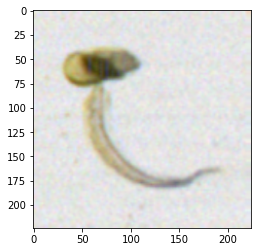

Pia1.2016-08-02.1631+N38_hc._fxy.tif
(224, 224, 3)


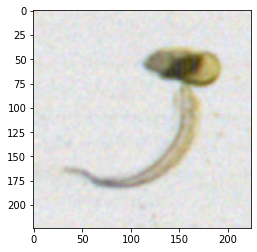

Pia1.2016-08-02.1631+N38_hc._fy.tif
(224, 224, 3)


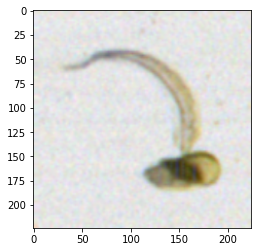

Pia1.2016-08-02.1631+N38_hc.tif
(224, 224, 3)


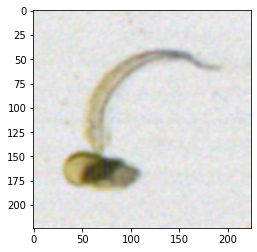

Pia1.2016-08-02.1631+N67_hc._fx.tif
(224, 224, 3)


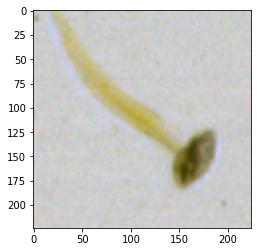

Pia1.2016-08-02.1631+N67_hc._fxy.tif
(224, 224, 3)


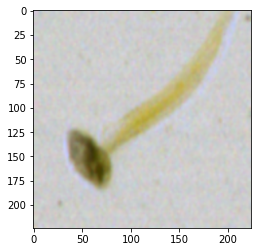

Pia1.2016-08-02.1631+N67_hc._fy.tif
(224, 224, 3)


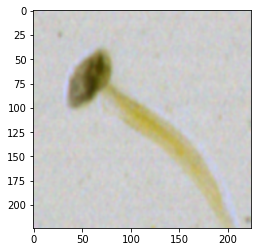

Pia1.2016-08-02.1631+N67_hc.tif
(224, 224, 3)


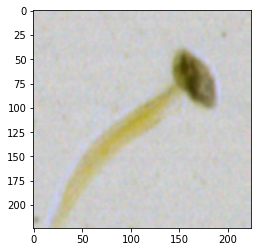

Pia1.2016-08-02.1631+N71_hc._fx.tif
(224, 224, 3)


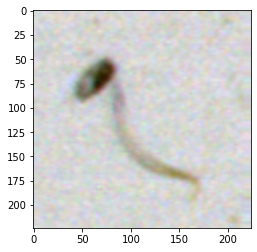

Pia1.2016-08-02.1631+N71_hc._fxy.tif
(224, 224, 3)


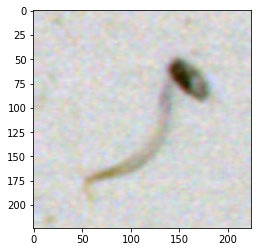

In [55]:
dataPath = '/data/images/'

for i in sorted(os.listdir(dataPath))[:10]:
    im = cv2.imread(dataPath + i)
    print(i)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im,(224,224))
    print(im.shape)
    imgplot = plt.imshow(im)
    plt.show()

# Load Data - Scivision
- Deduplicate and view labels & example image

In [2]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels = cat.labels().read()

labels_dedup = xr.Dataset.from_dataframe(
    labels
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

In [7]:
ds_labelled

<xarray.Dataset>
Dimensions:                               (channel: 3, concat_dim: 52894, x: 1040, y: 832)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2016-08-0...
  * concat_dim                            (concat_dim) int64 0 1 ... 58750 58751
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/27)
    raster                                (concat_dim, y, x, channel) uint8 dask.array<chunksize=(1, 832, 1040, 3), meta=np.ndarray>
    EXIF Image ImageWidth                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image ImageLength                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image BitsPerSample              (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image Compression                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image PhotometricInterpretation  (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                    ...
    EXIF GPS GPSLongitude                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image GPSInfo                    (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    index                                 (concat_dim) int64 142 143 ... 14787
    label1                                (concat_dim) object 'zooplankton' ....
    label2                                (concat_dim) object 'noncopepod' .....
    label3                                (concat_dim) object 'appendicularia...

Text(0.5, 1.0, 'Pia1.2016-08-02.1631+N38_hc._fxy.tif')

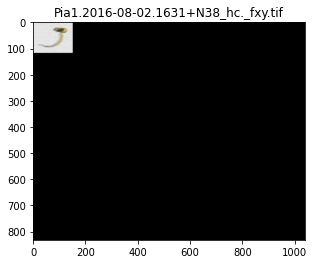

In [52]:
one_image = ds_labelled.sel(concat_dim=1)
plt.imshow(one_image['raster'].compute().values[:,:,:])
plt.title(one_image.filename.compute().values)

In [12]:
# get image width and length into columns
ds_labelled = ds_labelled.assign(
    image_width = ds_labelled['EXIF Image ImageWidth'].to_pandas().apply(lambda x: x.values[0]),
    image_length = ds_labelled['EXIF Image ImageLength'].to_pandas().apply(lambda x: x.values[0])
)

## Pre-processing options
- Masking or resizing
- RGB or Grayscale

In [17]:
def im_mask(one_image):
    mask = np.zeros_like(one_image.raster, dtype=bool)

    imw = one_image.image_width.values
    iml = one_image.image_length.values

    mask[0:iml, 0:imw, :] = True

    mask_da = xr.DataArray(mask, dims=["y", "x", "channel"])
    
    return one_image.raster.where(mask_da).fillna(255.0).astype(int)

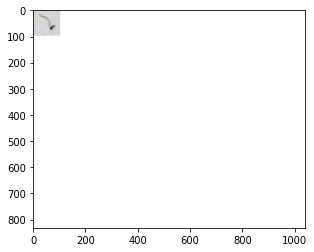

In [19]:
plt.imshow(im_mask(ds_labelled.sel(concat_dim=10)))